## Unsupervised tests on codebook

In [31]:
from src.preprocessing.preprocess_ucr import UCRDatasetImporter
from src.preprocessing.data_pipeline import build_data_pipeline
from src.utils import load_yaml_param_settings
from src.models.vqvae_classification import BaseVQVAE, remap_clusters
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import metrics
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

import umap
from sklearn.decomposition import PCA

In [32]:
config_dir = 'src/configs/config.yaml' #dir to config file

config = load_yaml_param_settings(config_dir)

# data pipeline
dataset_importer = UCRDatasetImporter(**config['dataset'])
batch_size = config['dataset']['batch_sizes']['vqvae']
train_data_loader, test_data_loader = [build_data_pipeline(batch_size, dataset_importer, config, kind) for kind in ['train', 'test']]

input_length = train_data_loader.dataset.X.shape[-1]

vqvae = BaseVQVAE(input_length, config)

self.X_train.shape: (30, 128)
self.X_test.shape: (900, 128)
# unique labels (train): [0 1 2]
# unique labels (test): [0 1 2]


### Embedding models

In [33]:
class UMAP_model:
    def __init__(self, model, n_comps=2): 
        self.model = model
        self.reducer = umap.UMAP(n_components=n_comps, metric="cosine")

    def fit(self, x_train, y_labs):
        train_embs = self.reducer.fit_transform(x_train)
        self.model.fit(train_embs, y_labs)

    def predict(self, x_test):
        test_embs = self.reducer.transform(x_test)
        return self.model.predict(test_embs)

class PCA_model:
    def __init__(self, model, var_explained_crit=0.9): 
        self.model = model
        self.pca = PCA(var_explained_crit)

    def fit(self, x_train, y_labs):
        train_embs = self.pca.fit_transform(x_train)
        self.model.fit(train_embs, y_labs)

    def predict(self, x_test):
        test_embs = self.pca.transform(x_test)
        preds = self.model.predict(test_embs)
        return preds

## Validation

In [34]:
def score(labs_true, labs_pred):
    print(f"rand score: {metrics.rand_score(labs_true, labs_pred)}")
    print(f"adjusted rand score: {metrics.adjusted_rand_score(labs_true, labs_pred)}")
    print(f"normalized mutual info score: {metrics.normalized_mutual_info_score(labs_true, labs_pred)}")

def UMAP_plots(X_test, labs_pred, labs_true):
    dens_mapper = umap.UMAP(densmap=True, n_components=2)
    embs = dens_mapper.fit_transform(X_test)


    f, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].scatter(embs[:, 0], embs[:, 1], c=labs_true); ax[0].set_title("true")
    ax[1].scatter(embs[:, 0], embs[:, 1], c=labs_pred); ax[1].set_title("predicted")

Grabbing zqs:

In [35]:
scaler_train_test = StandardScaler()

zqs_train, _ = vqvae.run_through_codebook(train_data_loader)
zqs_train_scaled = scaler_train_test.fit_transform(zqs_train)
y_train = train_data_loader.dataset.Y.flatten().astype(int)

zqs_test, _ = vqvae.run_through_codebook(test_data_loader)
zqs_test_scaled = scaler_train_test.transform(zqs_test)
y_test = test_data_loader.dataset.Y.flatten().astype(int)


zqs = np.concatenate((zqs_test, zqs_train), axis=0)
y = np.concatenate((y_test, y_train), axis=0)

scaler_zqs = StandardScaler()
zqs_scaled = scaler_zqs.fit_transform(zqs)

test_size = 0.2
Z_train, Z_test, Y_train, Y_test = train_test_split(zqs, y, test_size=test_size)
Z_train_scaled, Z_test_scaled, Y_train2, Y_test2 = train_test_split(zqs_scaled, y, test_size=test_size)

k = len(np.unique(y))

## Zero shot Kmeans classification
Testing kmeans on zqs_train and zqs_test

In [36]:
kmeans = KMeans(init="random", n_init=100, n_clusters=k, max_iter=300) 

kmeans.fit(zqs_train_scaled)

y_pred = kmeans.predict(zqs_test_scaled)
score(y_test, y_pred)

rand score: 0.6961339760227413
adjusted rand score: 0.33961155801723514
normalized mutual info score: 0.35130632570523823


Testing on splitted total zqs. With test size 0.2

In [37]:
kmeans = KMeans(init="random", n_init=10, n_clusters=k, max_iter=300) 
Y_pred = kmeans.fit_predict(zqs_scaled)
score(y, Y_pred)

rand score: 0.704191117747144
adjusted rand score: 0.3481045935706833
normalized mutual info score: 0.3520792696772595


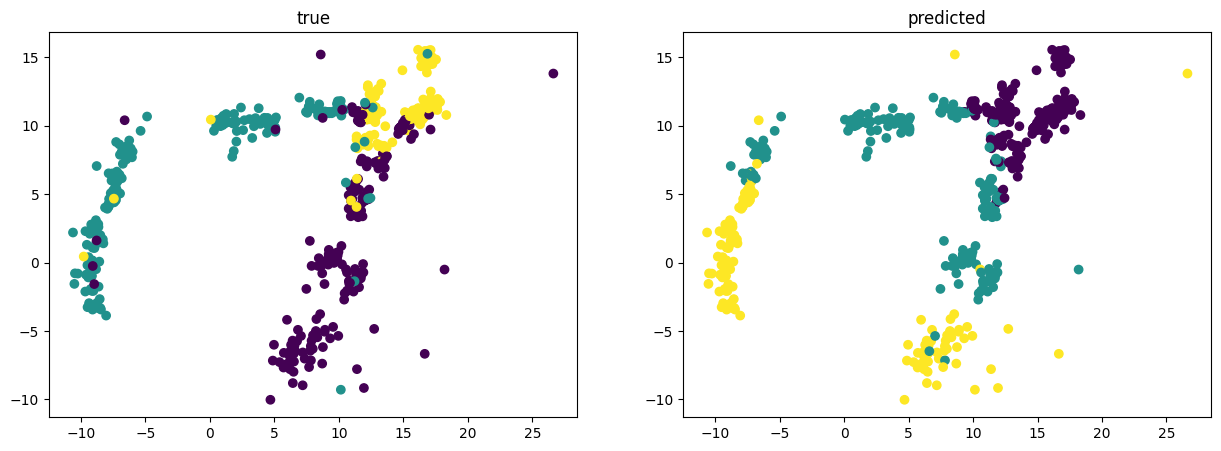

In [38]:
UMAP_plots(zqs, Y_pred, y)

#### Embedded kmeans:

In [39]:
pca_kmeans = PCA_model(
     KMeans(init="random", n_init=100, n_clusters=k, max_iter=300),
     var_explained_crit=0.95 #criteria for variance explained in the dim reduction
)

umap_kmeans = UMAP_model(
    KMeans(init="random", n_init=100, n_clusters=k, max_iter=300),
    n_comps=2
)

pca_kmeans.fit(Z_train_scaled, Y_train2) #dont use Y_train2 as it is unsupervised
umap_kmeans.fit(Z_train_scaled, Y_train2)

pca_kmeans_preds = pca_kmeans.predict(Z_test_scaled)
umap_kmeans_preds = umap_kmeans.predict(Z_test_scaled)

print("PCA kmeans")
score(Y_test2, pca_kmeans_preds)
print("UMAP kmeans")
score(Y_test2, umap_kmeans_preds)

PCA kmeans
rand score: 0.6971229293809938
adjusted rand score: 0.3331810536551321
normalized mutual info score: 0.3554963002278195
UMAP kmeans
rand score: 0.6317930834059866
adjusted rand score: 0.21457439759278593
normalized mutual info score: 0.27082947244638966


## HDB scan


In [40]:
reducer = umap.UMAP(metric="cosine")
umap_zqs = reducer.fit_transform(zqs_scaled)

In [41]:
from sklearn.cluster import HDBSCAN

hdbscan = HDBSCAN(min_cluster_size=20)
preds = hdbscan.fit(umap_zqs)
#score(y, preds)

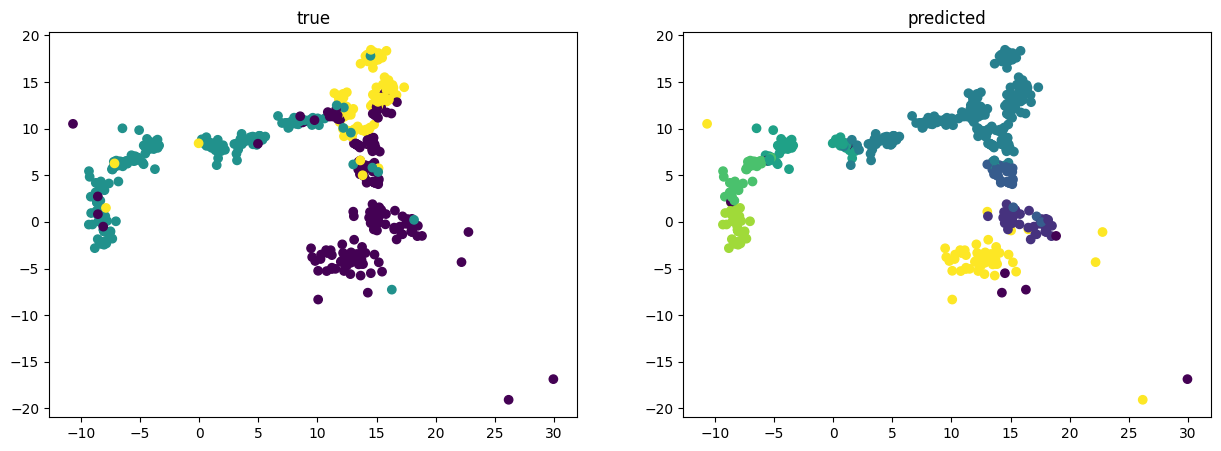

In [42]:
UMAP_plots(zqs, preds.labels_, y)